# Medical Expense Prediction
We will try and predict the Medical expenses from an individual based on factors like age, sex, bmi etc. so that the Insurance company can set the premium accordingly.

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Let's load our csv data into DataFrame
df = pd.read_csv("/content/drive/MyDrive/insurance.csv")

In [ ]:
# Get an understanding of the columns and rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
# Take a peek into data
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


### Data Cleaning

In [ ]:
# Let's check for nulls first
df.isnull().any().any()

False

Brilliant! None of the rows have any null values. Let's take columns and see if we have to clean any data.

In [ ]:
df.age.unique()

array([19, 18, 28, 33, 32, 31, 46, 37, 60, 25, 62, 23, 56, 27, 52, 30, 34,
       59, 63, 55, 22, 26, 35, 24, 41, 38, 36, 21, 48, 40, 58, 53, 43, 64,
       20, 61, 44, 57, 29, 45, 54, 49, 47, 51, 42, 50, 39])

In [ ]:
df.sex.unique()

array(['female', 'male'], dtype=object)

Since there are only 2 values, we can map male:1 and female:0

In [ ]:
df.sex.replace({'male':1, 'female':0}, inplace=True)

In [ ]:
df.bmi.describe()

count    1338.000000
mean       30.665471
std         6.098382
min        16.000000
25%        26.300000
50%        30.400000
75%        34.700000
max        53.100000
Name: bmi, dtype: float64

In [ ]:
df.children.unique()

array([0, 1, 3, 2, 5, 4])

In [ ]:
df.smoker.unique()

array(['yes', 'no'], dtype=object)

Since there are only 2 values, we can map yes:1 and no:0

In [ ]:
df.smoker.replace({'yes':1, 'no':0}, inplace=True)

In [ ]:
df.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

Since there are 4 unique values we'll have to use on-hot-encoding technique to deal with this.

In [ ]:
# Using Pandas get_dummies(), we can those new dummy columns.
# After that we dont need the original region column, dropping it.
# Concatenating the new dummy columns to the exisiting dataframe.
dummies = pd.get_dummies(data=df['region'], drop_first=True).rename(columns=lambda x: 'region_' + str(x))
df.drop(['region'], inplace=True, axis=1)
df = pd.concat([df, dummies], axis=1)

In [ ]:
df.expenses.describe()

count     1338.000000
mean     13270.422414
std      12110.011240
min       1121.870000
25%       4740.287500
50%       9382.030000
75%      16639.915000
max      63770.430000
Name: expenses, dtype: float64

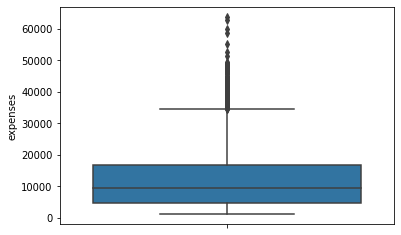

In [ ]:
sns.boxplot(y=df.expenses)

In [ ]:
df.expenses = df.expenses[df.expenses<50000]

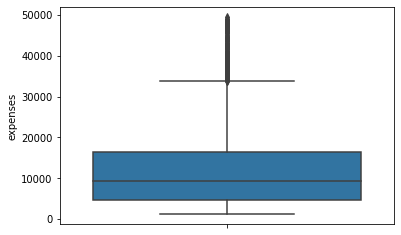

In [ ]:
sns.boxplot(y=df.expenses)

Seems like there are a lot of outlier data in our dependent variable. Since we don't have any evidence that these are typos or measurement errors, we will not be replacing these with any other value.

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1331 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1331 non-null   int64  
 1   sex               1331 non-null   int64  
 2   bmi               1331 non-null   float64
 3   children          1331 non-null   int64  
 4   smoker            1331 non-null   int64  
 5   expenses          1331 non-null   float64
 6   region_northwest  1331 non-null   uint8  
 7   region_southeast  1331 non-null   uint8  
 8   region_southwest  1331 non-null   uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 76.7 KB


We are done with data cleaning and preparation. <br>Let's have a look at the dataframe now.

In [ ]:
df.head()

,age,sex,bmi,children,smoker,expenses,region_northwest,region_southeast,region_southwest
0,19,0,27.9,0,1,16884.92,0,0,1
1,18,1,33.8,1,0,1725.55,0,1,0
2,28,1,33.0,3,0,4449.46,0,1,0
3,33,1,22.7,0,0,21984.47,1,0,0
4,32,1,28.9,0,0,3866.86,1,0,0


Now we will try to fit a model to this data and try to predict the expenses (dependent variable).

In [ ]:
x = df[df.columns[df.columns != 'expenses']]
y = df.expenses

In [ ]:
# Statsmodels.OLS requires us to add a constant.
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     503.5
Date:                Tue, 22 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:46:57   Log-Likelihood:                -13426.
No. Observations:                1331   AIC:                         2.687e+04
Df Residuals:                    1322   BIC:                         2.692e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.129e+04    954.105  

As we can see ,<br>R-squared: 0.753<br>Adj. R-squared: 0.752<hr>We also have p-values >0.05 for columns sex, region_northwest. We will remove these columns one by one and check the difference in the metrics of the model.

In [ ]:
x.drop('sex',axis=1, inplace=True)
model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     575.8
Date:                Tue, 22 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:47:20   Log-Likelihood:                -13426.
No. Observations:                1331   AIC:                         2.687e+04
Df Residuals:                    1323   BIC:                         2.691e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.133e+04    945.565  

R-squared:                       0.753<br>
Adj. R-squared:                  0.752<hr>
R-squared remains the same but Adj. R-squared increased. That is because, Adj.R-squared takes the number of columns into consideration, whereas R-squared does not. So it's always good to look at Adj. R-squared while removing/adding columns. In this case, removal of region_northwest has improved the model since Adj. R-squared increased and moved closer towards R-squared.

In [ ]:
x.drop('region_northwest',axis=1, inplace=True)
model = sm.OLS(y,x)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     671.6
Date:                Tue, 22 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:47:23   Log-Likelihood:                -13426.
No. Observations:                1331   AIC:                         2.687e+04
Df Residuals:                    1324   BIC:                         2.690e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.155e+04    917.289  

R-squared:                       0.753<br>
Adj. R-squared:                  0.752<hr>


So finally,<br>
**predicted_expense** = (**age** x 255.3) + (**bmi** x 318.62) + (**children** x 509.21) + (**smoker** x 23240) - (**region_southeast** x 777.08) - (**region_southwest** x 765.40)<br>
So, as we can see the highest factor that affects is if the person is a smoker or not! <mark>A smoker tends to pay 23,240 more medical expense than a non-smoker.<mark>